---
# Cairo University Faculty of Engineering
## Deep Learning 
## Assignment 7

---

Please write your full name here
- **Name** : Mariam Magued Habib Bebawy

# Assignment 7 VAE

# Debiasing Facial Detection Systems

Deploying fair, unbiased AI systems is critical to their long-term acceptance. Consider the task of facial detection: given an image, is it an image of a face?  This seemingly simple, but extremely important, task is subject to significant amounts of algorithmic bias among select demographics. 

In this assignment, we'll investigate [one recently published approach](http://introtodeeplearning.com/AAAI_MitigatingAlgorithmicBias.pdf) to addressing algorithmic bias. We'll build a facial detection model that learns the *latent variables* underlying face image datasets and uses this to adaptively re-sample the training data, thus mitigating any biases that may be present in order  to train a *debiased* model.


Run the next code block for a short video from Google that explores how and why it's important to consider bias when thinking about machine learning:

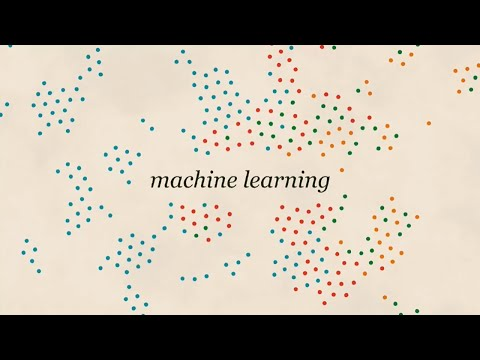

In [ ]:
import IPython
IPython.display.YouTubeVideo('59bMh59JQDo')

Let's get started by installing the relevant dependencies:

In [ ]:
# Import Tensorflow 2.0
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 24.4 MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-py3-none-any.whl size=2115441 sha256=343bf5ed907768e0a7ad52801e8e63a1814c5deb8173e2f35ac5a902d2f9fab9
  Stored in directory: /root/.cache/pip/wheels/2e/45/44/c5b304f31f37e8d2315f9e969fd8cdb0014a5c28608d0bf410
Successfully built mitdeeplearning


## 1 Datasets

We'll be using three datasets. In order to train our facial detection models, we'll need a dataset of positive examples (i.e., of faces) and a dataset of negative examples (i.e., of things that are not faces). We'll use these data to train our models to classify images as either faces or not faces. Finally, we'll need a test dataset of face images. Since we're concerned about the potential *bias* of our learned models against certain demographics, it's important that the test dataset we use has equal representation across the demographics or features of interest. In this lab, we'll consider skin tone and gender. 

1.   **Positive training data**: [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). A large-scale (over 200K images) of celebrity faces.   
2.   **Negative training data**: [ImageNet](http://www.image-net.org/). Many images across many different categories. We'll take negative examples from a variety of non-human categories. 
[Fitzpatrick Scale](https://en.wikipedia.org/wiki/Fitzpatrick_scale) skin type classification system, with each image labeled as "Lighter'' or "Darker''.

Let's begin by importing these datasets. We've written a class that does a bit of data pre-processing to import the training data in a usable format.

In [ ]:
# Get the training data: both images from CelebA and ImageNet
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')
# Instantiate a TrainingDatasetLoader using the downloaded dataset
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data)

1263889489/1263889489 [==============================] - 14s 0us/step
Opening /root/.keras/datasets/train_face.h5
Loading data into memory...


We can look at the size of the training dataset and grab a batch of size 100:

In [ ]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)
print(number_of_training_examples)

109914


Play around with displaying images to get a sense of what the training data actually looks like!

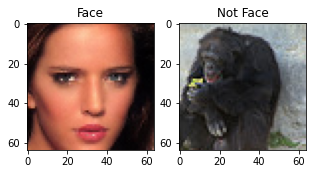

In [ ]:
### Examining the CelebA training dataset ###

#@title Change the sliders to look at positive and negative training examples! { run: "auto" }

face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 26 #@param {type:"slider", min:0, max:50, step:1}
idx_not_face = 26 #@param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face"); plt.grid(False)

### Thinking about bias

Remember we'll be training our facial detection classifiers on the large, well-curated CelebA dataset (and ImageNet), and then evaluating their accuracy by testing them on an independent test dataset. Our goal is to build a model that trains on CelebA *and* achieves high classification accuracy on the the test dataset across all demographics, and to thus show that this model does not suffer from any hidden bias. 

What exactly do we mean when we say a classifier is biased? In order to formalize this, we'll need to think about [*latent variables*](https://en.wikipedia.org/wiki/Latent_variable), variables that define a dataset but are not strictly observed. As defined in the generative modeling lecture, we'll use the term *latent space* to refer to the probability distributions of the aforementioned latent variables. Putting these ideas together, we consider a classifier *biased* if its classification decision changes after it sees some additional latent features.

## 2 CNN for facial detection 

First, we'll define and train a CNN on the facial classification task, and evaluate its accuracy. Later, we'll evaluate the performance of our debiased models against this baseline CNN. The CNN model has a relatively standard architecture consisting of a series of convolutional layers with batch normalization followed by two fully connected layers to flatten the convolution output and generate a class prediction. 

### Define and train the CNN model

We'll define our CNN model, and then train on the CelebA and ImageNet datasets using the `tf.GradientTape` class and the `tf.GradientTape.gradient` method.

In [ ]:
### Define the CNN model ###

n_filters = 12 # base number of convolutional filters

'''Function to define a standard CNN model'''
def make_standard_classifier(n_outputs=1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')

  model = tf.keras.Sequential([
    Conv2D(filters=1*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),
    
    Conv2D(filters=2*n_filters, kernel_size=5,  strides=2),
    BatchNormalization(),

    Conv2D(filters=4*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Conv2D(filters=6*n_filters, kernel_size=3,  strides=2),
    BatchNormalization(),

    Flatten(),
    Dense(512),
    Dense(n_outputs, activation=None),
  ])
  return model

standard_classifier = make_standard_classifier()

Now let's train the standard CNN!

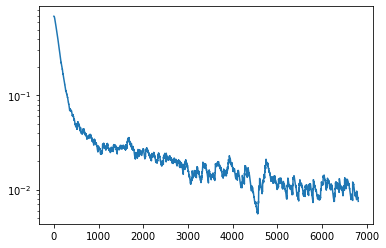

100%|██████████| 3434/3434 [00:37<00:00, 90.86it/s]


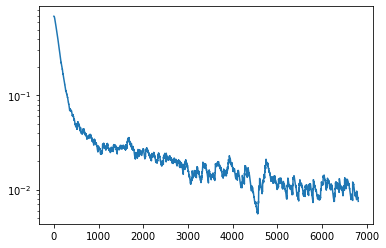

In [ ]:
### Train the standard CNN ###

# Training hyperparameters
batch_size = 32
num_epochs = 2  # keep small to run faster
learning_rate = 5e-4

optimizer = tf.keras.optimizers.Adam(learning_rate) # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def standard_train_step(x, y):
  with tf.GradientTape() as tape:
    # feed the images into the model
    logits = standard_classifier(x) 
    # Compute the loss
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

  # Backpropagation
  grads = tape.gradient(loss, standard_classifier.trainable_variables)
  optimizer.apply_gradients(zip(grads, standard_classifier.trainable_variables))
  return loss

# The training loop!
for epoch in range(num_epochs):
  for idx in tqdm(range(loader.get_train_size()//batch_size)):
    # Grab a batch of training data and propagate through the network
    x, y = loader.get_batch(batch_size)
    loss = standard_train_step(x, y)

    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

### Evaluate performance of the standard CNN

Next, let's evaluate the classification performance of our CelebA-trained standard CNN on the training dataset.


In [ ]:
### Evaluation of standard CNN ###

# TRAINING DATA
# Evaluate on a subset of CelebA+Imagenet
(batch_x, batch_y) = loader.get_batch(5000)
y_pred_standard = tf.round(tf.nn.sigmoid(standard_classifier.predict(batch_x)))
acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))

print("Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(acc_standard.numpy()))

157/157 [==============================] - 1s 3ms/step
Standard CNN accuracy on (potentially biased) training set: 0.9964


We will also evaluate our networks on an independent test dataset containing faces that were not seen during training. For the test data, we'll look at the classification accuracy across four different demographics, based on the Fitzpatrick skin scale and sex-based labels: dark-skinned male, dark-skinned female, light-skinned male, and light-skinned female. 

Let's take a look at some sample faces in the test set. 

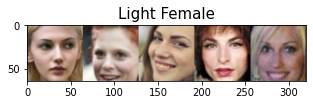

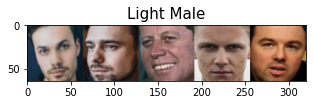

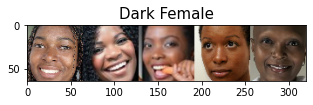

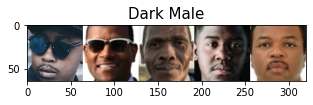

In [ ]:
### Load test dataset and plot examples ###

test_faces = mdl.lab2.get_test_faces()
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]
for group, key in zip(test_faces,keys): 
  plt.figure(figsize=(5,5))
  plt.imshow(np.hstack(group))
  plt.title(key, fontsize=15)

Now, let's evaluated the probability of each of these face demographics being classified as a face using the standard CNN classifier we've just trained. 

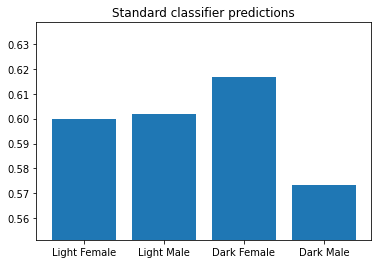

In [ ]:
### Evaluate the standard CNN on the test data ### 

standard_classifier_logits = [standard_classifier(np.array(x, dtype=np.float32)) for x in test_faces]
standard_classifier_probs = tf.squeeze(tf.sigmoid(standard_classifier_logits))

# Plot the prediction accuracies per demographic
xx = range(len(keys))
yy = standard_classifier_probs.numpy().mean(1)
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0,yy.min()-yy.ptp()/2.), yy.max()+yy.ptp()/2.)
plt.title("Standard classifier predictions");

# Question:
Take a look at the accuracies for this first model across these four groups.
1. What do you observe? Would you consider this model biased or unbiased? 
2. What are some reasons why a trained model may have biased accuracies? 
3. If a model is biased, suggest a naive solution to the bias problem. What's the problem with this naive solution?

**Answers:**  
1. "Dark Male" ----> lowest accuracy ----> model is mainly biased against "Dark Male"  
"Dark Female" ----> highest accuracy ----> model may be biased to "Dark Female" (i.e., more prone to classify "Dark Female" than other categories)

2. data could be biased against "Dark Male" (i.e., less number)  
certain features could be taken into consideration, e.g. glasses

3. data augmentation for "Dark Male"  
possible data reduction for "Dark Female"  
problem ----> can never capture the universal features of classes


## 3 Mitigating algorithmic bias


Another solution that's not naive is to actually **learn** the features underlying the data in an unbiased, unsupervised manner and then train a classifier fairly with respect to these features.

## 4 Variational autoencoder (VAE) for learning latent structure

As you saw, the accuracy of the CNN varies across the four demographics we looked at. 

Our goal is to train a *debiased* version of this classifier -- one that accounts for potential disparities in feature representation within the training data. Specifically, to build a debiased facial classifier, we'll train a model that **learns a representation of the underlying latent space** to the face training data. The model then uses this information to mitigate unwanted biases by sampling faces with rare features, like dark skin or hats, *more frequently* during training. The key design requirement for our model is that it can learn an *encoding* of the latent features in the face data in an entirely *unsupervised* way. To achieve this, we'll turn to variational autoencoders (VAEs).

![The concept of a VAE](https://upload.wikimedia.org/wikipedia/commons/2/24/Reparameterized_Variational_Autoencoder.jpg)

As shown in the schematic above and in Lecture, VAEs rely on an encoder-decoder structure to learn a latent representation of the input data. In the context of computer vision, the encoder network takes in input images, encodes them into a series of variables defined by a mean and standard deviation, and then draws from the distributions defined by these parameters to generate a set of sampled latent variables. The decoder network then "decodes" these variables to generate a reconstruction of the original image, which is used during training to help the model identify which latent variables are important to learn. 

Let's formalize two key aspects of the VAE model and define relevant functions for each.


### Understanding VAEs: loss function

In practice, how can we train a VAE? In learning the latent space, we constrain the means and standard deviations to approximately follow a unit Gaussian. Recall that these are learned parameters, and therefore must factor into the loss computation, and that the decoder portion of the VAE is using these parameters to output a reconstruction that should closely match the input image, which also must factor into the loss. What this means is that we'll have two terms in our VAE loss function:

1.  **Latent loss ($L_{KL}$)**: measures how closely the learned latent variables match a unit Gaussian and is defined by the Kullback-Leibler (KL) divergence.
2.   **Reconstruction loss ($L_{x}{(x,\hat{x})}$)**: measures how accurately the reconstructed outputs match the input and is given by the $L^1$ norm of the input image and its reconstructed output.

The equation for the latent loss is provided by:

$$L_{KL}(\mu, \sigma) = \frac{1}{2}\sum_{j=0}^{k-1} (\sigma_j + \mu_j^2 - 1 - \log{\sigma_j})$$

The equation for the reconstruction loss is provided by:

$$L_{x}{(x,\hat{x})} = ||x-\hat{x}||_1$$

Thus for the VAE loss we have:

$$L_{VAE} = c\cdot L_{KL} + L_{x}{(x,\hat{x})}$$

where $c$ is a weighting coefficient used for regularization. Now we're ready to define our VAE loss function:

In [ ]:
### Defining the VAE loss function ###

''' Function to calculate VAE loss given:
      an input x, 
      reconstructed output x_recon, 
      encoded means mu, 
      encoded log of standard deviation logsigma, 
      weight parameter for the latent loss kl_weight
'''
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  # TODO: Define the latent loss. Note this is given in the equation for L_{KL}
  # in the text block directly above
  latent_loss = 0.5 * tf.reduce_sum((tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma), axis=1) # TODO

  # TODO: Define the reconstruction loss as the mean absolute pixel-wise 
  # difference between the input and reconstruction. Hint: you'll need to 
  # use tf.reduce_mean, and supply an axis argument which specifies which 
  # dimensions to reduce over. For example, reconstruction loss needs to average 
  # over the height, width, and channel image dimensions.
  # https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
  reconstruction_loss = tf.reduce_mean(tf.abs(x - x_recon), axis=(1, 2, 3))# TODO

  # TODO: Define the VAE loss. Note this is given in the equation for L_{VAE}
  # in the text block directly above
  vae_loss = kl_weight*latent_loss + reconstruction_loss # TODO
  
  return vae_loss

### Understanding VAEs: reparameterization 

VAEs use a "reparameterization  trick" for sampling learned latent variables. Instead of the VAE encoder generating a single vector of real numbers for each latent variable, it generates a vector of means and a vector of standard deviations that are constrained to roughly follow Gaussian distributions. We then sample from the standard deviations and add back the mean to output this as our sampled latent vector. Formalizing this for a latent variable $z$ where we sample $\epsilon \sim \mathcal{N}(0,(I))$ we have: 

$$z = \mu + e^{\left(\frac{1}{2} \cdot \log{\Sigma}\right)}\circ \epsilon$$

where $\mu$ is the mean and $\Sigma$ is the covariance matrix. This is useful because it will let us neatly define the loss function for the VAE, generate randomly sampled latent variables, achieve improved network generalization, **and** make our complete VAE network differentiable so that it can be trained via backpropagation. Quite powerful!

Let's define a function to implement the VAE sampling operation:

In [ ]:
### VAE Reparameterization ###

"""Reparameterization trick by sampling from an isotropic unit Gaussian.
# Arguments
    z_mean, z_logsigma (tensor): mean and log of standard deviation of latent distribution (Q(z|X))
# Returns
    z (tensor): sampled latent vector
"""
def sampling(z_mean, z_logsigma):
  # By default, random.normal is "standard" (ie. mean=0 and std=1.0)
  batch, latent_dim = z_mean.shape
  epsilon = tf.random.normal(shape=(batch, latent_dim))

  # TODO: Define the reparameterization computation!
  # Note the equation is given in the text block immediately above.
  z = z_mean + tf.exp(z_logsigma/2)*epsilon # TODO
    
  return z

## 5 Debiasing variational autoencoder (DB-VAE)

Now, we'll use the general idea behind the VAE architecture to build a model, termed a [*debiasing variational autoencoder*](https://lmrt.mit.edu/sites/default/files/AIES-19_paper_220.pdf) or DB-VAE, to mitigate (potentially) unknown biases present within the training idea. We'll train our DB-VAE model on the facial detection task, run the debiasing operation during training, evaluate on the PPB dataset, and compare its accuracy to our original, biased CNN model.    

### The DB-VAE model

The key idea behind this debiasing approach is to use the latent variables learned via a VAE to adaptively re-sample the CelebA data during training. Specifically, we will alter the probability that a given image is used during training based on how often its latent features appear in the dataset. So, faces with rarer features (like dark skin, sunglasses, or hats) should become more likely to be sampled during training, while the sampling probability for faces with features that are over-represented in the training dataset should decrease (relative to uniform random sampling across the training data). 

A general schematic of the DB-VAE approach is shown here:

![DB-VAE](https://raw.githubusercontent.com/aamini/introtodeeplearning/2019/lab2/img/DB-VAE.png)

Recall that we want to apply our DB-VAE to a *supervised classification* problem -- the facial detection task. Importantly, note how the encoder portion in the DB-VAE architecture also outputs a single supervised variable, $z_o$, corresponding to the class prediction -- face or not face. Usually, VAEs are not trained to output any supervised variables (such as a class prediction)! This is another key distinction between the DB-VAE and a traditional VAE. 

Keep in mind that we only want to learn the latent representation of *faces*, as that's what we're ultimately debiasing against, even though we are training a model on a binary classification problem. We'll need to ensure that, **for faces**, our DB-VAE model both learns a representation of the unsupervised latent variables, captured by the distribution $q_\phi(z|x)$, **and** outputs a supervised class prediction $z_o$, but that, **for negative examples**, it only outputs a class prediction $z_o$.

### Defining the DB-VAE loss function

This means we'll need to be a bit clever about the loss function for the DB-VAE. The form of the loss will depend on whether it's a face image or a non-face image that's being considered. 

For **face images**, our loss function will have two components:


1.   **VAE loss ($L_{VAE}$)**: consists of the latent loss and the reconstruction loss.
2.   **Classification loss ($L_y(y,\hat{y})$)**: standard cross-entropy loss for a binary classification problem. 

In contrast, for images of **non-faces**, our loss function is solely the classification loss. 

We can write a single expression for the loss by defining an indicator variable $\mathcal{I}_f$which reflects which training data are images of faces ($\mathcal{I}_f(y) = 1$ ) and which are images of non-faces ($\mathcal{I}_f(y) = 0$). Using this, we obtain:

$$L_{total} = L_y(y,\hat{y}) + \mathcal{I}_f(y)\Big[L_{VAE}\Big]$$

Let's write a function to define the DB-VAE loss function:



In [ ]:
### Loss function for DB-VAE ###

"""Loss function for DB-VAE.
# Arguments
    x: true input x
    x_pred: reconstructed x
    y: true label (face or not face)
    y_logit: predicted labels
    mu: mean of latent distribution (Q(z|X))
    logsigma: log of standard deviation of latent distribution (Q(z|X))
# Returns
    total_loss: DB-VAE total loss
    classification_loss = DB-VAE classification loss
"""
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):

  # TODO: call the relevant function to obtain VAE loss
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma) # TODO

  # TODO: define the classification loss using sigmoid_cross_entropy
  # https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit) # TODO

  # Use the training data labels to create variable face_indicator:
  #   indicator that reflects which training data are images of faces
  face_indicator = tf.cast(tf.equal(y, 1), tf.float32)

  # TODO: define the DB-VAE total loss! Use tf.reduce_mean to average over all
  # samples
  total_loss = tf.reduce_mean(classification_loss + face_indicator*vae_loss) # TODO

  return total_loss, classification_loss

### DB-VAE architecture

Now we're ready to define the DB-VAE architecture. To build the DB-VAE, we will use the standard CNN classifier from above as our encoder, and then define a decoder network. We will create and initialize the two models, and then construct the end-to-end VAE. We will use a latent space with 100 latent variables.

The decoder network will take as input the sampled latent variables, run them through a series of deconvolutional layers, and output a reconstruction of the original input image.

In [ ]:
### Define the decoder portion of the DB-VAE ###

n_filters = 12 # base number of convolutional filters, same as standard CNN
latent_dim = 100 # number of latent variables

def make_face_decoder_network():
  # Functionally define the different layer types we will use
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  BatchNormalization = tf.keras.layers.BatchNormalization
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  # Build the decoder network using the Sequential API
  decoder = tf.keras.Sequential([
    # Transform to pre-convolutional generation
    Dense(units=4*4*6*n_filters),  # 4x4 feature maps (with 6N occurances)
    Reshape(target_shape=(4, 4, 6*n_filters)),

    # Upscaling convolutions (inverse of encoder)
    Conv2DTranspose(filters=4*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=2*n_filters, kernel_size=3,  strides=2),
    Conv2DTranspose(filters=1*n_filters, kernel_size=5,  strides=2),
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),
  ])

  return decoder

Now, we will put this decoder together with the standard CNN classifier as our encoder to define the DB-VAE. Note that at this point, there is nothing special about how we put the model together that makes it a "debiasing" model -- that will come when we define the training operation. Here, we will define the core VAE architecture by sublassing the `Model` class; defining encoding, reparameterization, and decoding operations; and calling the network end-to-end.

In [ ]:
### Defining and creating the DB-VAE ###

class DB_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(DB_VAE, self).__init__()
    self.latent_dim = latent_dim

    # Define the number of outputs for the encoder. Recall that we have 
    # `latent_dim` latent variables, as well as a supervised output for the 
    # classification.
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_classifier(num_encoder_dims)
    self.decoder = make_face_decoder_network()

  # function to feed images into encoder, encode the latent space, and output
  #   classification probability 
  def encode(self, x):
    # encoder output
    encoder_output = self.encoder(x)

    # classification prediction
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    # latent variable distribution parameters
    z_mean = encoder_output[:, 1:self.latent_dim+1] 
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  # VAE reparameterization: given a mean and logsigma, sample latent variables
  def reparameterize(self, z_mean, z_logsigma):
    # TODO: call the sampling function defined above
    z = sampling(z_mean, z_logsigma) # TODO
    
    return z

  # Decode the latent space and output reconstruction
  def decode(self, z):
    # TODO: use the decoder to output the reconstruction
    reconstruction = self.decoder(z) # TODO
    
    return reconstruction

  # The call function will be used to pass inputs x through the core VAE
  def call(self, x): 
    # Encode input to a prediction and latent space
    y_logit, z_mean, z_logsigma = self.encode(x)

    # TODO: reparameterization
    z = self.reparameterize(z_mean, z_logsigma) # TODO

    # TODO: reconstruction
    recon = self.decode(z) # TODO
    
    return y_logit, z_mean, z_logsigma, recon

  # Predict face or not face logit for given input x
  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit

dbvae = DB_VAE(latent_dim)

As stated, the encoder architecture is identical to the CNN from earlier i. 

# Question
Note the outputs of our constructed DB_VAE model in the `call` function: `y_logit, z_mean, z_logsigma, z`. Define each of the outputs and comment on why they are outputted and their significance to the problem at hand.


1. **y_logit definition**: // encoder output //  
encoder prediction of image, face or not a face

2. **z_mean**: // encoder output //  
describes the distribution of latent space through the mean variable

3. **z_logsigma**: // encoder output //  
decribes the distribution of latent space


4. **z**: // decoder input //  
reparametrization technique  
uses mean and logsigma to sample data from the latent space  
feeds sample data as input to the decoder for image reconstruction  

### Adaptive resampling for automated debiasing with DB-VAE

So, how can we actually use DB-VAE to train a debiased facial detection classifier?

Recall the DB-VAE architecture: as input images are fed through the network, the encoder learns an estimate $\mathcal{Q}(z|X)$ of the latent space. We want to increase the relative frequency of rare data by increased sampling of under-represented regions of the latent space. We can approximate $\mathcal{Q}(z|X)$ using the frequency distributions of each of the learned latent variables, and then define the probability distribution of selecting a given datapoint $x$ based on this approximation. These probability distributions will be used during training to re-sample the data.

You'll write a function to execute this update of the sampling probabilities, and then call this function within the DB-VAE training loop to actually debias the model. 

First, we've defined a short helper function `get_latent_mu` that returns the latent variable means returned by the encoder after a batch of images is inputted to the network:

In [ ]:
# Function to return the means for an input image batch
def get_latent_mu(images, dbvae, batch_size=1024):
  N = images.shape[0]
  mu = np.zeros((N, latent_dim))
  for start_ind in range(0, N, batch_size):
    end_ind = min(start_ind+batch_size, N+1)
    batch = (images[start_ind:end_ind]).astype(np.float32)/255.
    _, batch_mu, _ = dbvae.encode(batch)
    mu[start_ind:end_ind] = batch_mu
  return mu

Now, let's define the actual resampling algorithm `get_training_sample_probabilities`. Importantly note the argument `smoothing_fac`. This parameter tunes the degree of debiasing: for `smoothing_fac=0`, the re-sampled training set will tend towards falling uniformly over the latent space, i.e., the most extreme debiasing.

In [ ]:
### Resampling algorithm for DB-VAE ###

'''Function that recomputes the sampling probabilities for images within a batch
      based on how they distribute across the training data'''
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001): 
    print("Recomputing the sampling probabilities")
    
    # TODO: run the input batch and get the latent variable means
    mu = get_latent_mu(images, dbvae) # TODO

    # sampling probabilities for the images
    training_sample_p = np.zeros(mu.shape[0])
    
    # consider the distribution for each latent variable 
    for i in range(latent_dim):
      
        latent_distribution = mu[:,i]
        # generate a histogram of the latent distribution
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)

        # find which latent bin every data sample falls in 
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')
        
        # TODO: call the digitize function to find which bins in the latent distribution 
        #    every data sample falls in to
        # https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.digitize.html
        bin_idx = np.digitize(latent_distribution, bin_edges) # TODO

        # smooth the density function
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)

        # invert the density function 
        p = 1.0/(hist_smoothed_density[bin_idx-1])
        
        # TODO: normalize all probabilities
        p = p / np.sum(p) # TODO
        
        # TODO: update sampling probabilities by considering whether the newly
        #     computed p is greater than the existing sampling probabilities.
        training_sample_p = np.maximum(p, training_sample_p) # TODO
        
    # final normalization
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

Now that we've defined the resampling update, we can train our DB-VAE model on the CelebA/ImageNet training data, and run the above operation to re-weight the importance of particular data points as we train the model. Remember again that we only want to debias for features relevant to *faces*, not the set of negative examples. Complete the code block below to execute the training loop!

Starting epoch 6/6
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

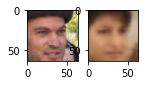

 14%|█▍        | 494/3434 [00:05<00:29, 100.53it/s]

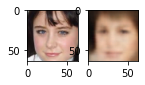

 29%|██▉       | 995/3434 [00:10<00:25, 96.10it/s]

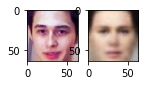

 44%|████▎     | 1496/3434 [00:15<00:19, 97.76it/s]

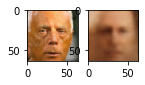

 58%|█████▊    | 2000/3434 [00:21<00:15, 95.53it/s]

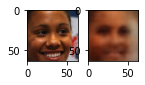

 73%|███████▎  | 2497/3434 [00:26<00:09, 97.34it/s]

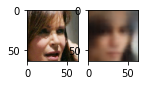

 87%|████████▋ | 2999/3434 [00:31<00:04, 102.47it/s]

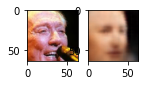

100%|██████████| 3434/3434 [00:36<00:00, 95.10it/s] 


In [ ]:
### Training the DB-VAE ###

# Hyperparameters
batch_size = 32
learning_rate = 5e-4
latent_dim = 100

# DB-VAE needs slightly more epochs to train since its more complex than 
# the standard classifier so we use 6 instead of 2
num_epochs = 6  

# instantiate a new DB-VAE model and optimizer
dbvae = DB_VAE(100)
optimizer = tf.keras.optimizers.Adam(learning_rate)

# To define the training operation, we will use tf.function which is a powerful tool 
#   that lets us turn a Python function into a TensorFlow computation graph.
@tf.function
def debiasing_train_step(x, y):

  with tf.GradientTape() as tape:
    # Feed input x into dbvae. Note that this is using the DB_VAE call function!
    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)

    '''TODO: call the DB_VAE loss function to compute the loss'''
    loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma) # TODO
  
  '''TODO: use the GradientTape.gradient method to compute the gradients.
     Hint: this is with respect to the trainable_variables of the dbvae.'''
  grads = tape.gradient(loss, dbvae.trainable_variables) # TODO

  # apply gradients to variables
  optimizer.apply_gradients(zip(grads, dbvae.trainable_variables))
  return loss

# get training faces from data loader
all_faces = loader.get_all_train_faces()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# The training loop -- outer loop iterates over the number of epochs
for i in range(num_epochs):

  IPython.display.clear_output(wait=True)
  print("Starting epoch {}/{}".format(i+1, num_epochs))

  # Recompute data sampling proabilities
  '''TODO: recompute the sampling probabilities for debiasing'''
  p_faces = get_training_sample_probabilities(all_faces, dbvae) # TODO
  
  # get a batch of training data and compute the training step
  for j in tqdm(range(loader.get_train_size() // batch_size)):
    # load a batch of data
    (x, y) = loader.get_batch(batch_size, p_pos=p_faces)
    # loss optimization
    loss = debiasing_train_step(x, y)
    
    # plot the progress every 200 steps
    if j % 500 == 0: 
      mdl.util.plot_sample(x, y, dbvae)

Wonderful! Now we should have a trained and (hopefully!) debiased facial classification model, ready for evaluation!

## 6 Evaluation of DB-VAE on test dataset

Finally let's test our DB-VAE model on the test dataset, looking specifically at its accuracy on each the "Dark Male", "Dark Female", "Light Male", and "Light Female" demographics. We will compare the performance of this debiased model against the (potentially biased) standard CNN from earlier in the lab.

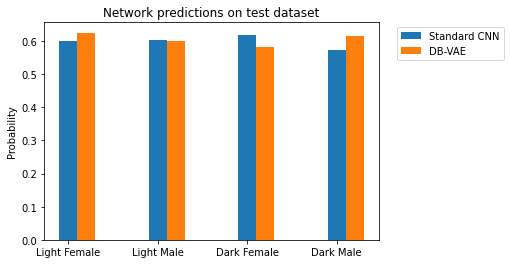

In [ ]:
dbvae_logits = [dbvae.predict(np.array(x, dtype=np.float32)) for x in test_faces]
dbvae_probs = tf.squeeze(tf.sigmoid(dbvae_logits))

xx = np.arange(len(keys))
plt.bar(xx, standard_classifier_probs.numpy().mean(1), width=0.2, label="Standard CNN")
plt.bar(xx+0.2, dbvae_probs.numpy().mean(1), width=0.2, label="DB-VAE")
plt.xticks(xx, keys); 
plt.title("Network predictions on test dataset")
plt.ylabel("Probability"); plt.legend(bbox_to_anchor=(1.04,1), loc="upper left");


## Questions:

1.  How does the accuracy of the DB-VAE across the four demographics compare to that of the standard CNN? Do you find this result surprising in any way?
2.  How can the performance of the DB-VAE classifier be improved even further?
3. In which applications (either related to facial detection or not!) would debiasing in this way be desired? Are there applications where you may not want to debias your model? 
4. Do you think it should be necessary for companies to demonstrate that their models, particularly in the context of tasks like facial detection, are not biased? If so, do you have thoughts on how this could be standardized and implemented?
5. Do you have ideas for other ways to address issues of bias, particularly in terms of the training data?

Try to optimize your model to achieve improved performance.


![The concept of a VAE](https://i.ibb.co/BjLSRMM/ezgif-2-253dfd3f9097.gif)

**Answers:**  
1. accuracies across classes are all close ----> intended output through DBVAE  
not surprising ----> resampling through DBVAE allows for a better distribution of probabilities accross classes

2. more complex encoder (CNN) architecture  
image pre-processing techniques such as contrast stretching

3. desired ----> face detection, bioimaging and biosignal classifications  
not desired ----> data with unbiased distribution

4. yes, as this is has been a common issue for the past few years  
new test datasets could be formulated once in a while through people's consent and possibly police records as well  

5. data augmentation for classes with lower numbers  
accurate labeling of data  
removing duplicate entries  

In [ ]:
#Copyright MIT